PROBLEM STATEMENT

XYZ.com is an e-commerce company based in Argentina. [Issues due to covid and lockdown}]

XYZ.com has lots of product data where mentioned 
  - shipping details
  - sales details of each product.

To reduce customer escalation, 
XYZ.com wants to find out?
 - which of the products has been shipped / canceled ?               


To predict which of the products has been shipped / canceled.
As a data-scientist, we have to train 
  -a PCA model to visualize its higher-dimensional data 
  - an LDA(Linear Discriminant Analysis) model 


In [ ]:
import pandas as pd
import numpy as np
from datetime import *

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from scipy.stats import zscore


from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_squared_log_error

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost
from xgboost import XGBRegressor


from sklearn.preprocessing import scale

In [ ]:
df=pd.read_csv("sales_data_sample.csv",engine="python", encoding="ISO-8859-1")
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


# Data Preprocessing

In [ ]:
df["STATUS"].unique()

array(['Shipped', 'Disputed', 'In Process', 'Cancelled', 'On Hold',
       'Resolved'], dtype=object)

In [ ]:
df=df.drop("ADDRESSLINE1", axis=1)
df=df.drop("ADDRESSLINE2", axis=1)
df=df.drop("CONTACTLASTNAME", axis=1)
df=df.drop("CONTACTFIRSTNAME", axis=1)
df=df.drop("CUSTOMERNAME", axis=1)
df = df.drop("MONTH_ID",axis=1)
df = df.drop("ORDERNUMBER",axis=1)
df=df.drop("YEAR_ID",axis=1)
df = df.drop("CITY",axis=1)
df = df.drop("STATE",axis=1)
df = df.drop("TERRITORY",axis=1)


In [ ]:
df["DEALSIZE"]=df["DEALSIZE"].replace({'Small':0,'Medium':1,'Large':2})

order_ts=[]
for od in df.ORDERDATE:
  od_value=datetime.strptime(od.split()[0],'%m/%d/%Y')
  od_ts = datetime.timestamp(od_value)
  order_ts.append(int(od_ts))
df["ORDER_TS"]=order_ts
df=df.drop("ORDERDATE",axis=1)

postal_code_dict={}
post_ind=0
for post in df["POSTALCODE"].unique():
  postal_code_dict[post]=post_ind
  post_ind+=1
df["POSTALCODE"]=df["POSTALCODE"].replace(postal_code_dict)

status_code_dict={}
status_ind=0
for order_status in df["STATUS"].unique():
  status_code_dict[order_status]=status_ind
  status_ind+=1

df["STATUS"]=df["STATUS"].replace(status_code_dict)

productline_dict={}
productline_ind=0
for product_line in df["PRODUCTLINE"].unique():
  productline_dict[product_line]=productline_ind
  productline_ind+=1

df["PRODUCTLINE"]=df["PRODUCTLINE"].replace(productline_dict)


country_dict={}
country_ind=0
for country in df["COUNTRY"].unique():
  country_dict[country]=country_ind
  country_ind+=1
df["COUNTRY"]=df["COUNTRY"].replace(country_dict)

phone_dict={}
phone_ind=0
for phone in df["PHONE"].unique():
  phone_dict[phone]=phone_ind
  phone_ind+=1
df["PHONE"]=df["PHONE"].replace(phone_dict)

productcode_dict={}
productcode_ind=0
for product_code in df["PRODUCTCODE"].unique():
  productcode_dict[product_code]=productcode_ind
  productcode_ind+=1
df["PRODUCTCODE"]=df["PRODUCTCODE"].replace(productcode_dict)

df.head()


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,STATUS,QTR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,PHONE,POSTALCODE,COUNTRY,DEALSIZE,ORDER_TS
0,30,95.70,2,2871.00,0,1,0,95,0,0,0,0,0,1046044800
1,34,81.35,5,2765.90,0,2,0,95,0,1,1,1,0,1052265600
2,41,94.74,2,3884.34,0,3,0,95,0,2,2,1,1,1057017600
3,45,83.26,6,3746.70,0,3,0,95,0,3,3,0,1,1061769600
4,49,100.00,14,5205.27,0,4,0,95,0,4,4,0,1,1065744000


In [ ]:
Y=df["STATUS"]
X= df.drop("STATUS",axis=1)


# Principle Component Analysis
- Used for dimensionality reduction from 13 to 10.

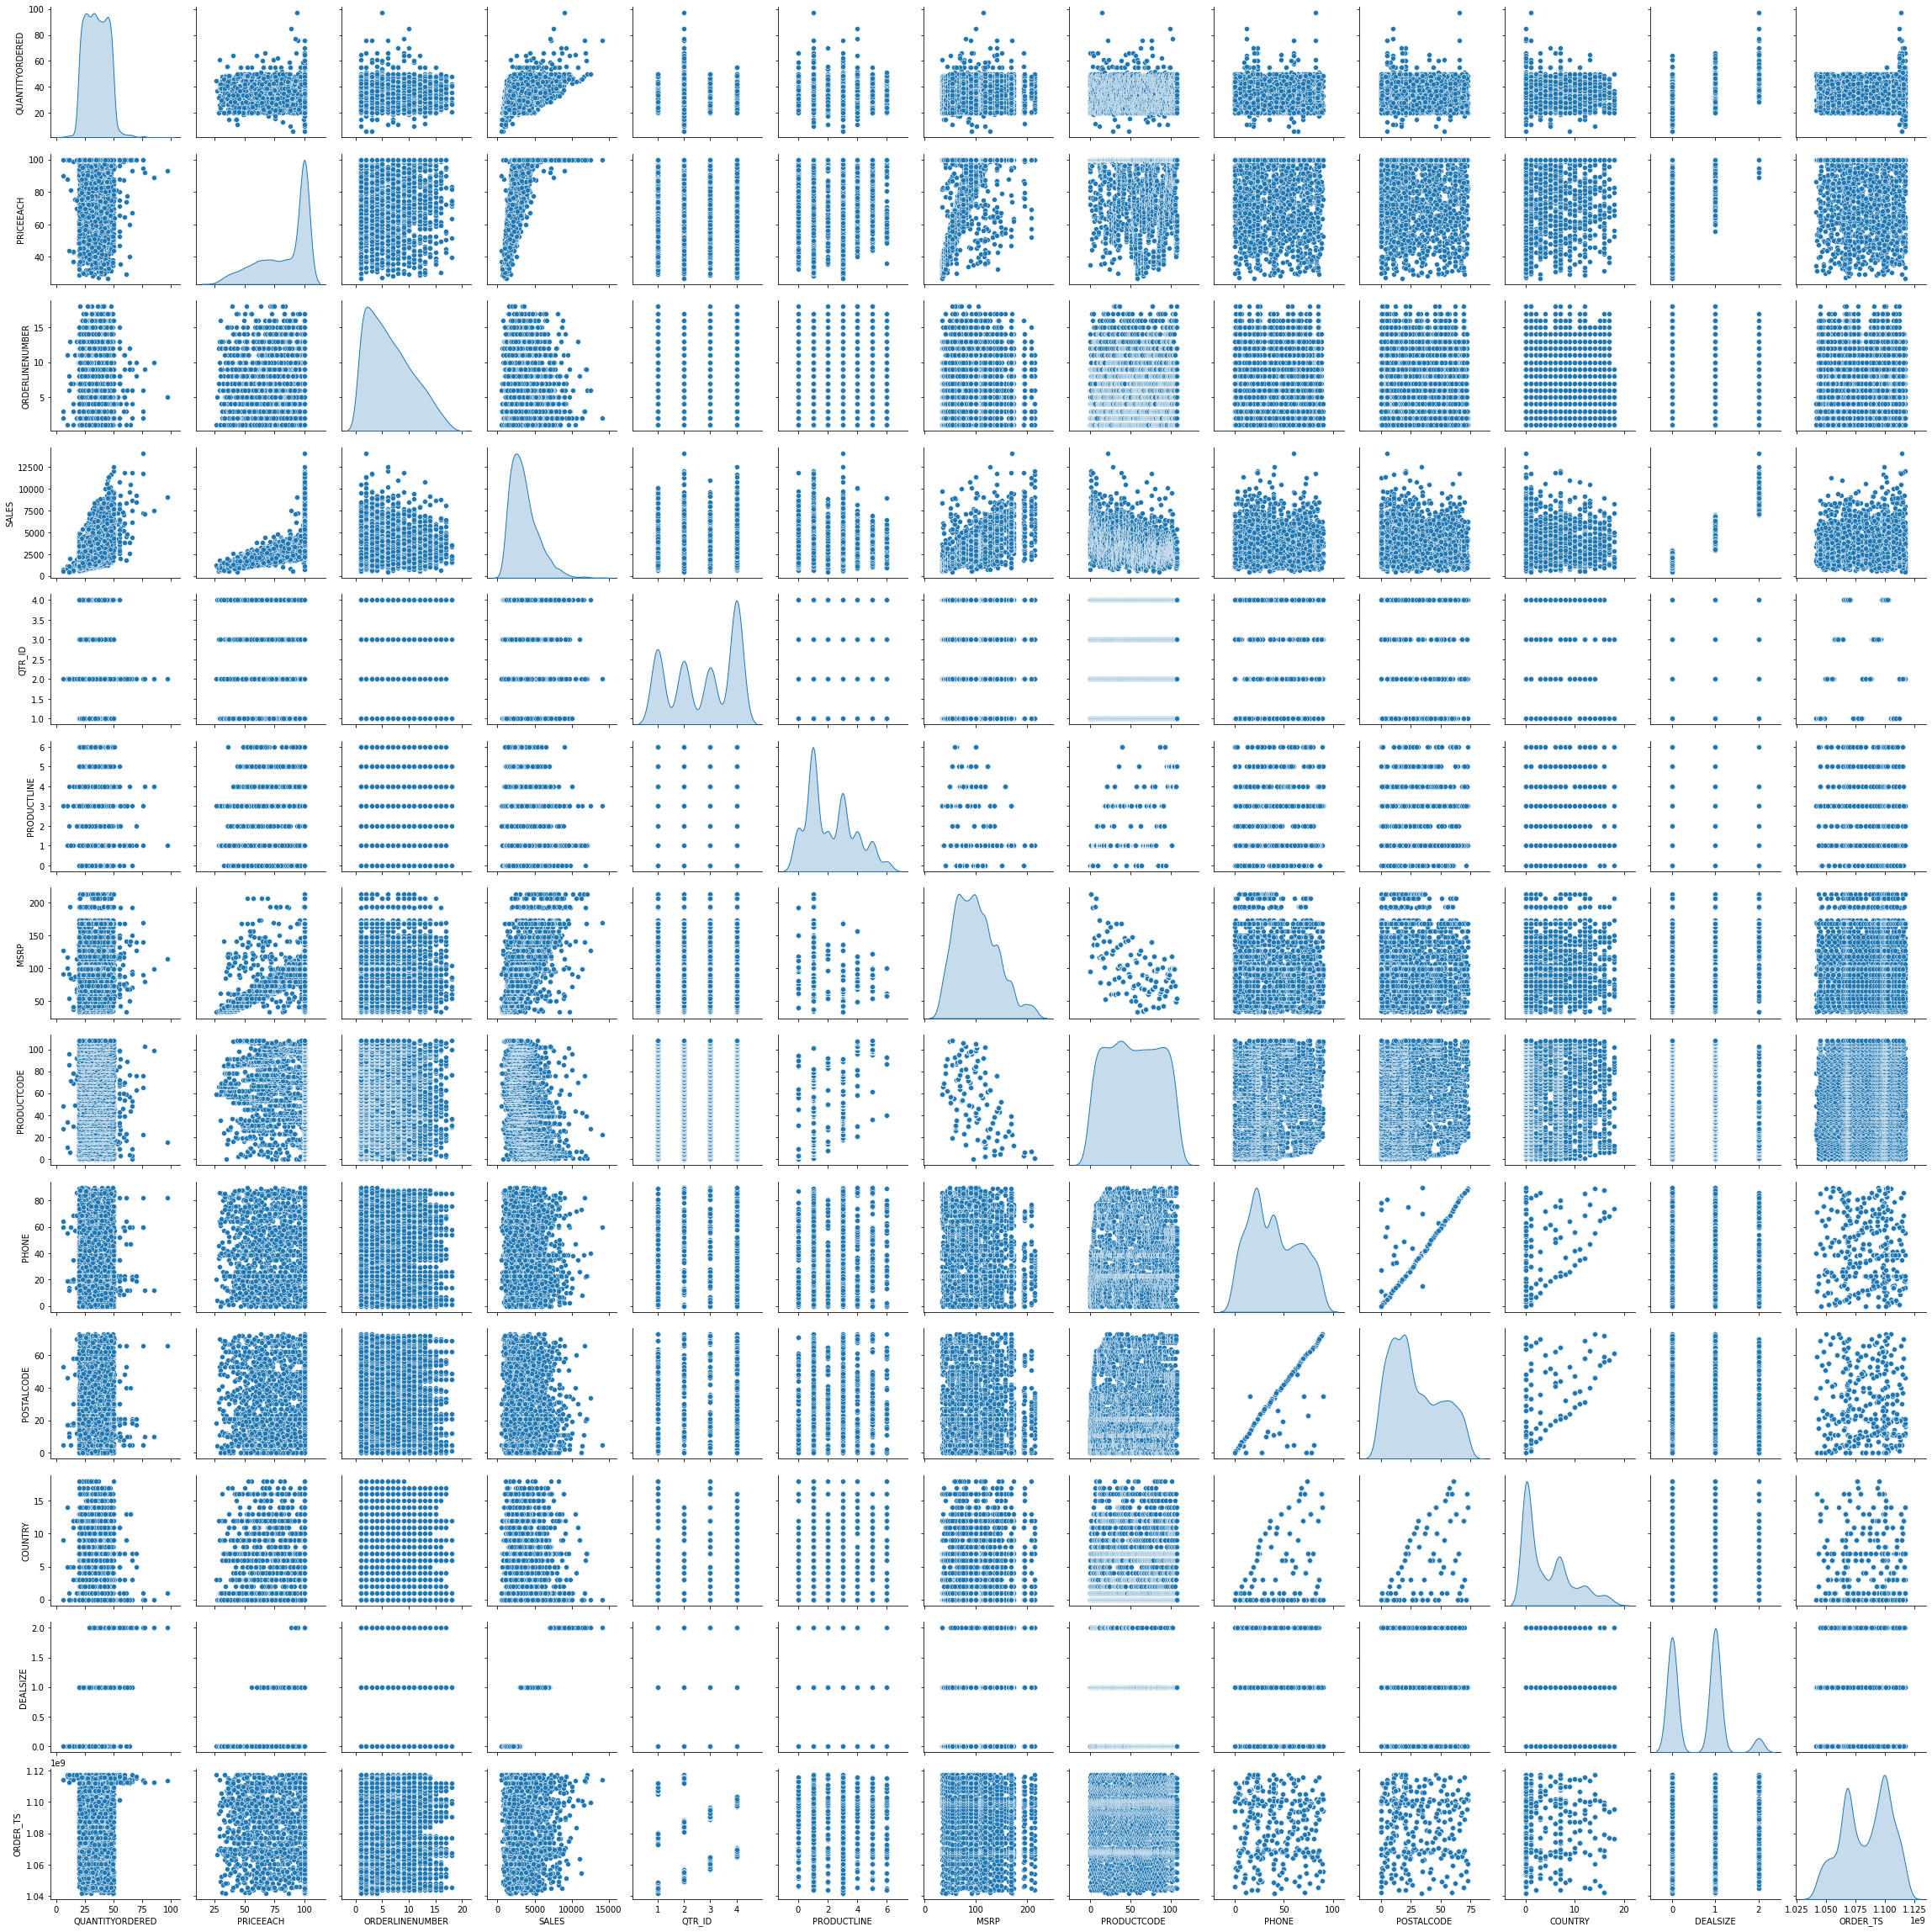

In [ ]:
#Visually inspect the covariance between independent dimensions and between mpg and independent dimensions
sns.pairplot(X, diag_kind='kde')

Significant linear relations are found between these columns 
1. [PHONE,POSTALCODE, COUNTRY]
2. [QUANTITY_ORDERED, MSRP, PRICEEACH, SALES, DEALSIZE]


In [ ]:
# Priciple components Part 1
pc1_x = X[["PHONE","POSTALCODE","COUNTRY"]]

# Principle components part 2
pc2_x=X[["QUANTITYORDERED", "MSRP", "PRICEEACH", "SALES", "DEALSIZE"]]


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   QUANTITYORDERED  2823 non-null   int64  
 1   PRICEEACH        2823 non-null   float64
 2   ORDERLINENUMBER  2823 non-null   int64  
 3   SALES            2823 non-null   float64
 4   QTR_ID           2823 non-null   int64  
 5   PRODUCTLINE      2823 non-null   int64  
 6   MSRP             2823 non-null   int64  
 7   PRODUCTCODE      2823 non-null   int64  
 8   PHONE            2823 non-null   int64  
 9   POSTALCODE       2823 non-null   int64  
 10  COUNTRY          2823 non-null   int64  
 11  DEALSIZE         2823 non-null   int64  
 12  ORDER_TS         2823 non-null   int64  
dtypes: float64(2), int64(11)
memory usage: 286.8 KB


In [ ]:
rem_x=X[["ORDERLINENUMBER","QTR_ID","PRODUCTLINE","PRODUCTCODE","ORDER_TS"]]
rem_x.head()


,ORDERLINENUMBER,QTR_ID,PRODUCTLINE,PRODUCTCODE,ORDER_TS
0,2,1,0,0,1046044800
1,5,2,0,0,1052265600
2,2,3,0,0,1057017600
3,6,3,0,0,1061769600
4,14,4,0,0,1065744000


In [ ]:
def principle_components(x,dim):
  sc = StandardScaler()

  x_std =  sc.fit_transform(x)
  cov_matrix = np.cov(x_std.T)
  eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
  # Sort eigenvalues in descending order
  print(eigenvectors)
  # Make a set of (eigenvalue, eigenvector) pairs
  eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]
  print(eig_pairs)
  # Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
  eig_pairs.sort()

  eig_pairs.reverse()
  # Extract the descending ordered eigenvalues and eigenvectors
  eigvalues_sorted = [eig_pairs[index][0] for index in range(len(eigenvalues))]
  eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]

  p_reduce = np.array(eigvectors_sorted[0:dim])   # Reducing from 8 to 4 dimension space

  print(p_reduce.T)
  x_std_4D = np.dot(x_std,p_reduce.T)   # projecting original data into principal component dimensions

  proj_data_df = pd.DataFrame(x_std_4D)  # converting array to dataframe for pairplot
  return proj_data_df


In [ ]:
pc1_x_std=principle_components(pc1_x,2)
pc1_x_std.head()

[[-0.5940742  -0.62297739 -0.50889587]
 [-0.64347514  0.74767036 -0.16409988]
 [-0.48271688 -0.22997433  0.84504214]]
[(2.1330797696824497, array([-0.5940742 , -0.64347514, -0.48271688])), (0.1762078858597294, array([-0.62297739,  0.74767036, -0.22997433])), (0.6917754202905677, array([-0.50889587, -0.16409988,  0.84504214]))]
[[-0.5940742  -0.50889587]
 [-0.64347514 -0.16409988]
 [-0.48271688  0.84504214]]


,0,1
0,2.260867,0.285584
1,2.106954,0.430904
2,2.052229,0.402587
3,2.096692,0.200633
4,2.041967,0.172316


In [ ]:
pc2_x_std=principle_components(pc2_x,3)
pc2_x_std.head()

[[-0.25339199 -0.79069611 -0.31477119 -0.44314877 -0.1230058 ]
 [-0.4342819   0.40639487 -0.19126457 -0.12709919 -0.77039347]
 [-0.4465202   0.40541924 -0.21166405 -0.48367688  0.59792136]
 [-0.53238386 -0.16231006  0.83075664  0.0017213   0.00795646]
 [-0.51417785 -0.13759927 -0.3596925   0.74398835  0.18382115]]
[(3.166813125107886, array([-0.25339199, -0.4342819 , -0.4465202 , -0.53238386, -0.51417785])), (1.1844729490048296, array([-0.79069611,  0.40639487,  0.40541924, -0.16231006, -0.13759927])), (0.1036720621333099, array([-0.31477119, -0.19126457, -0.21166405,  0.83075664, -0.3596925 ])), (0.2093395211536812, array([-0.44314877, -0.12709919, -0.48367688,  0.0017213 ,  0.74398835])), (0.3374741356548612, array([-0.1230058 , -0.77039347,  0.59792136,  0.00795646,  0.18382115]))]
[[-0.25339199 -0.79069611 -0.1230058 ]
 [-0.4342819   0.40639487 -0.77039347]
 [-0.4465202   0.40541924  0.59792136]
 [-0.53238386 -0.16231006  0.00795646]
 [-0.51417785 -0.13759927  0.18382115]]


,0,1,2
0,0.647202,0.797566,0.341256
1,0.891187,0.193673,-0.135093
2,-0.778648,-0.436329,0.488557
3,-0.588788,-0.979670,0.097143
4,-1.485097,-1.096492,0.549152


In [ ]:
pc1_x_std.rename(columns={0:"c10",1:"c11"},inplace=True)
pc2_x_std.rename(columns={0:"c20",1:"c21",2:"c22"},inplace=True)
print(pc1_x_std.columns)
print(pc2_x_std.columns)
sc=StandardScaler()
rem_x_std =  pd.DataFrame(sc.fit_transform(rem_x))

Index(['c10', 'c11'], dtype='object')
Index(['c20', 'c21', 'c22'], dtype='object')


In [ ]:

X=pd.concat([pc1_x_std,pc2_x_std],axis=1,join='inner')
X_std=pd.concat([X,rem_x_std],axis=1,join='inner')
X_std.head()

,c10,c11,c20,c21,c22,0,1,2,3,4
0,2.260867,0.285584,0.647202,0.797566,0.341256,-1.057059,-1.427039,-1.372844,-1.70278,-1.916812
1,2.106954,0.430904,0.891187,0.193673,-0.135093,-0.347015,-0.596243,-1.372844,-1.70278,-1.604579
2,2.052229,0.402587,-0.778648,-0.436329,0.488557,-1.057059,0.234553,-1.372844,-1.70278,-1.366068
3,2.096692,0.200633,-0.588788,-0.979670,0.097143,-0.110334,0.234553,-1.372844,-1.70278,-1.127557
4,2.041967,0.172316,-1.485097,-1.096492,0.549152,1.783116,1.065350,-1.372844,-1.70278,-0.928075


In [ ]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: STATUS, dtype: int64

# Regression Models Analysis

In [ ]:
x_train_sc,x_test_sc,y_train,y_test = train_test_split(X_std,Y,test_size=0.15,random_state=0)

def fit_n_print(model,x_train,y_train,x_test,y_test,name,_step):
    model.fit(x_train.values,y_train)
    y_test_pred=model.predict(x_test.values)

    print("\nResults for", type(model).__name__+":")
    print("*******************************")
    rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))
    print("Root mean squared error: ",rmse)
    r2 = r2_score(y_test,y_test_pred)
    print("R-squared: ", r2)
    mean_abs_err = mean_absolute_error(y_test,y_test_pred)
    print("Mean Absolute Error: ",mean_abs_err)



lr=LinearRegression()
fit_n_print(lr,x_train_sc,y_train,x_test_sc,y_test,'Linear Regression',1)
	
knn=KNeighborsRegressor()
fit_n_print(knn,x_train_sc,y_train,x_test_sc,y_test,'KNeighbors Regressor',2)
	
dtr=DecisionTreeRegressor(random_state=0)
fit_n_print(dtr,x_train_sc,y_train,x_test_sc,y_test,'Decision Tree Regressor',3)
	
rfr=RandomForestRegressor(random_state=0)
fit_n_print(rfr,x_train_sc,y_train,x_test_sc,y_test,'Random Forest Regressor',4)

gb = GradientBoostingRegressor()
fit_n_print(gb,x_train_sc,y_train,x_test_sc,y_test,'GradientBoosting Regressor',5)

abr=AdaBoostRegressor(random_state=0)
fit_n_print(abr,x_train_sc,y_train,x_test_sc,y_test,'AdaBoost Regressor',6)


Results for LinearRegression:
*******************************
Root mean squared error:  0.7263665595307893
R-squared:  -0.009325074838786751
Mean Absolute Error:  0.40666682103670604

Results for KNeighborsRegressor:
*******************************
Root mean squared error:  0.682531359428835
R-squared:  0.10882170790103751
Mean Absolute Error:  0.2443396226415094

Results for DecisionTreeRegressor:
*******************************
Root mean squared error:  0.25234746934141994
R-squared:  0.8781803671189146
Mean Absolute Error:  0.02122641509433962

Results for RandomForestRegressor:
*******************************
Root mean squared error:  0.25612865281426994
R-squared:  0.8745023165735568
Mean Absolute Error:  0.06797169811320755

Results for GradientBoostingRegressor:
*******************************
Root mean squared error:  0.27335115345152305
R-squared:  0.8570575569492188
Mean Absolute Error:  0.13101843863424298

Results for AdaBoostRegressor:
*******************************
Root

# Linear Disciminant Analysis

In [ ]:
# Prepare training and test data and scale it
X = np.asmatrix(X)
X = scale(X)
Y = np.asarray(Y)
#Build LDA Model
clf = LinearDiscriminantAnalysis()
model=clf.fit(x_train_sc.values, y_train)
# Predict it
pred_class = model.predict(x_test_sc.values)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [ ]:
print("Classification report of Linear Disciminant analysis")
print(classification_report(y_test, pred_class))

Classification report of Linear Disciminant analysis
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       404
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         4

    accuracy                           0.95       424
   macro avg       0.16      0.17      0.16       424
weighted avg       0.91      0.95      0.93       424



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
